In [3]:
from sumpy.recurrence import _make_sympy_vec, get_processed_and_shifted_recurrence

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)

from sumpy.recurrence import get_recurrence, _generate_nd_derivative_relations, pde_to_ode_in_r, ode_in_r_to_x

import sympy as sp
from sympy import hankel1

import numpy as np

import math

import matplotlib.pyplot as plt
from matplotlib import cm, ticker

In [4]:
from sumpy.expansion.diff_op import DerivativeIdentifier, LinearPDESystemOperator
from immutabledict import immutabledict

In [5]:
var = _make_sympy_vec("x", 2)
_generate_nd_derivative_relations(var, 5)

{f_r0: f_x0,
 f_r1: f_x1*sqrt(x0**2 + x1**2)/x0,
 f_r2: -f_x1*x1**2/x0**3 + f_x2 + f_x2*x1**2/x0**2,
 f_r3: 3*f_x1*x1**2*sqrt(x0**2 + x1**2)/x0**5 - 3*f_x2*x1**2*sqrt(x0**2 + x1**2)/x0**4 + f_x3*sqrt(x0**2 + x1**2)/x0 + f_x3*x1**2*sqrt(x0**2 + x1**2)/x0**3,
 f_r4: -12*f_x1*x1**2/x0**5 - 15*f_x1*x1**4/x0**7 + 12*f_x2*x1**2/x0**4 + 15*f_x2*x1**4/x0**6 - 6*f_x3*x1**2/x0**3 - 6*f_x3*x1**4/x0**5 + f_x4 + 2*f_x4*x1**2/x0**2 + f_x4*x1**4/x0**4,
 f_r5: 60*f_x1*x1**2*sqrt(x0**2 + x1**2)/x0**7 + 105*f_x1*x1**4*sqrt(x0**2 + x1**2)/x0**9 - 60*f_x2*x1**2*sqrt(x0**2 + x1**2)/x0**6 - 105*f_x2*x1**4*sqrt(x0**2 + x1**2)/x0**8 + 30*f_x3*x1**2*sqrt(x0**2 + x1**2)/x0**5 + 45*f_x3*x1**4*sqrt(x0**2 + x1**2)/x0**7 - 10*f_x4*x1**2*sqrt(x0**2 + x1**2)/x0**4 - 10*f_x4*x1**4*sqrt(x0**2 + x1**2)/x0**6 + f_x5*sqrt(x0**2 + x1**2)/x0 + 2*f_x5*x1**2*sqrt(x0**2 + x1**2)/x0**3 + f_x5*x1**4*sqrt(x0**2 + x1**2)/x0**5}

In [6]:
def get_ode_in_x(x_order, y_order):
    single_partial = DerivativeIdentifier((x_order,y_order), 0)
    #Coefficients
    list_pde_dict = immutabledict({single_partial: 1})
    random_pde = LinearPDESystemOperator(2,(list_pde_dict,))

    ode_in_r_random, var, ode_order_random = pde_to_ode_in_r(random_pde)
    ode_in_x_random = ode_in_r_to_x(ode_in_r_random, var, ode_order_random).simplify()

    return ode_in_x_random

In [8]:
n_rows = 1
n_cols = 1
table = []
for i in range(n_rows):
    temp = []
    for j in range(n_cols):
        temp.append(get_ode_in_x(i, j))
    table.append(temp)

In [8]:
table

[[f_x0,
  f_x1*x1/x0,
  (f_x1*x0**2 - f_x1*x1**2 + f_x2*x0*x1**2)/x0**3,
  x1*(-3*f_x1*x0**2 + 3*f_x1*x1**2 + 3*f_x2*x0**3 - 3*f_x2*x0*x1**2 + f_x3*x0**2*x1**2)/x0**5],
 [f_x1,
  x1*(-f_x1 + f_x2*x0)/x0**2,
  (-f_x1*x0**2 + 3*f_x1*x1**2 + f_x2*x0**3 - 3*f_x2*x0*x1**2 + f_x3*x0**2*x1**2)/x0**4,
  x1*(9*f_x1*x0**2 - 15*f_x1*x1**2 - 9*f_x2*x0**3 + 15*f_x2*x0*x1**2 + 3*f_x3*x0**4 - 6*f_x3*x0**2*x1**2 + f_x4*x0**3*x1**2)/x0**6],
 [f_x2,
  x1*(2*f_x1 - 2*f_x2*x0 + f_x3*x0**2)/x0**3,
  (2*f_x1*x0**2 - 12*f_x1*x1**2 - 2*f_x2*x0**3 + 12*f_x2*x0*x1**2 + f_x3*x0**4 - 5*f_x3*x0**2*x1**2 + f_x4*x0**3*x1**2)/x0**5,
  x1*(-36*f_x1*x0**2 + 90*f_x1*x1**2 + 36*f_x2*x0**3 - 90*f_x2*x0*x1**2 - 15*f_x3*x0**4 + 39*f_x3*x0**2*x1**2 + 3*f_x4*x0**5 - 9*f_x4*x0**3*x1**2 + f_x5*x0**4*x1**2)/x0**7],
 [f_x3,
  x1*(-6*f_x1 + 6*f_x2*x0 - 3*f_x3*x0**2 + f_x4*x0**3)/x0**4,
  (-6*f_x1*x0**2 + 60*f_x1*x1**2 + 6*f_x2*x0**3 - 60*f_x2*x0*x1**2 - 3*f_x3*x0**4 + 27*f_x3*x0**2*x1**2 + f_x4*x0**5 - 7*f_x4*x0**3*x1**2 + f_x5*x0

In [10]:
var = _make_sympy_vec("x", 2)
_generate_nd_derivative_relations(var, 2)

{f_r0: f_x0,
 f_r1: f_x1*sqrt(x0**2 + x1**2)/x0,
 f_r2: -f_x1*x1**2/x0**3 + f_x2 + f_x2*x1**2/x0**2}

In [11]:
var = _make_sympy_vec("x", 2)
var_t = _make_sympy_vec("t", 2)
abs_dist = sp.sqrt((var[0]-var_t[0])**2 +
                    (var[1]-var_t[1])**2)
k = 1
g_x_y = (1j/4) * hankel1(0, k * abs_dist)
derivs = [sp.diff(g_x_y,
                    var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                                            for i in range(6)]

In [24]:
var = _make_sympy_vec("x", 2)
var_t = _make_sympy_vec("t", 2)
g_x_y = sp.log(sp.sqrt((var[0]-var_t[0])**2 + (var[1]-var_t[1])**2))

In [25]:
import time
times = []
n_d = 8
for i in range(n_d):
    start = time.time()
    sp.diff(g_x_y, var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
    end = time.time()
    times.append(end-start)

In [26]:
x_a = np.array([i+1 for i in range(n_d)])
times = np.array(times)

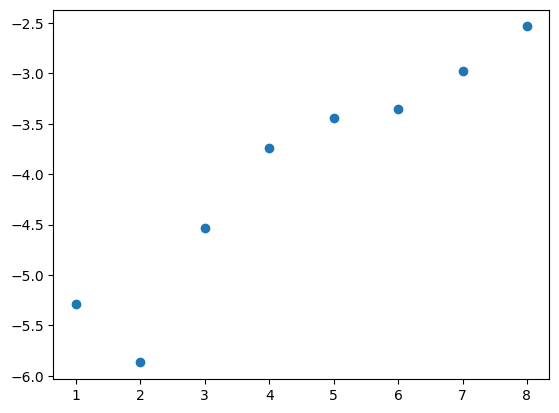

In [27]:
import matplotlib.pyplot as plt
plt.scatter(x_a,np.log(times))